In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import warnings
warnings.filterwarnings('ignore')

# Read recipe inputs
non_labeled_images = dataiku.Folder("Y2CfEnR1")
non_labeled_images_info = non_labeled_images.get_info()

In [2]:
import os

dataiku_folder_id = 'Y2CfEnR1'  
dataiku_folder = dataiku.Folder(dataiku_folder_id)
folder_path = dataiku_folder.get_path()

# List the contents of the folder
contents = os.listdir(folder_path)

print("Contents of the folder:")
for item in contents:
    print(item)

Contents of the folder:
Train
Test
model_unsampled.pt


In [3]:
import os
import torch
from torchvision import datasets, transforms

# Update the data_dir variable with the correct path from your Dataiku project
data_dir = dataiku_folder.get_path()

data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256, 256)),  # Adjust the size as needed
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((256, 256)),  # Adjust the size as needed
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Debug: Print the contents of data_transforms
print("Contents of data_transforms:")
for key, value in data_transforms.items():
    print(f"{key}: {value}")

# Assuming your Dataiku folder has subfolders 'Train' and 'Test' for training and testing sets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms.get(x, None))
                  for x in ['Train', 'Test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['Train', 'Test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Contents of data_transforms:
Train: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [4]:
class_names

['not suitable', 'suitable']

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


Inputs shape: torch.Size([4, 3, 256, 256])
Classes shape: torch.Size([4])


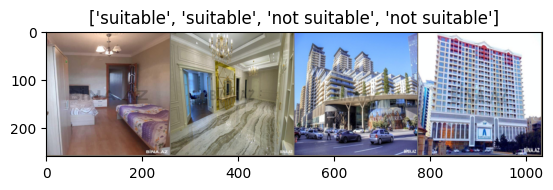

In [6]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms

inputs, classes = next(iter(dataloaders['Train']))

# Print information about the tensors
print("Inputs shape:", inputs.shape)
print("Classes shape:", classes.shape)

# Visualize the batch of images
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

In [8]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'Train_loss': [], 'Train_acc': [], 'Test_loss': [], 'Test_acc': []}

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['Train', 'Test']:  # Use lowercase for consistency
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Update history for both train and test phases
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history


In [9]:
def visualize_model(model, dataloaders, writer, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']): 

            inputs = inputs.to(device)
            labels = labels.to(device)
            writer.add_graph(model, inputs)  # modelimize grafik ekleyelim
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 1, images_so_far)
                ax.axis('off')
                color = 'blue'
                if preds[j] == labels[j]:
                    color = 'green'
                else:
                    color = 'red'
                ax.set_title('L = {} \t Pred: {}'.format(class_names[labels[j]],class_names[preds[j]]), c=color)
                fig = plt.figure(figsize=(8, 8))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [11]:
exp_lr_scheduler.get_last_lr()[0]

0.001

In [12]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_ft.state_dict():
    print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

In [13]:
model_ft, training_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=10)


Epoch 0/9
----------
Train Loss: 0.3214 Acc: 0.8854
Test Loss: 0.0098 Acc: 1.0000

Epoch 1/9
----------
Train Loss: 0.3191 Acc: 0.8824
Test Loss: 0.0029 Acc: 1.0000

Epoch 2/9
----------
Train Loss: 0.3133 Acc: 0.8974
Test Loss: 0.0018 Acc: 1.0000

Epoch 3/9
----------
Train Loss: 0.2258 Acc: 0.9276
Test Loss: 0.0166 Acc: 1.0000

Epoch 4/9
----------
Train Loss: 0.2202 Acc: 0.9306
Test Loss: 0.0068 Acc: 1.0000

Epoch 5/9
----------
Train Loss: 0.2026 Acc: 0.9382
Test Loss: 0.0067 Acc: 1.0000

Epoch 6/9
----------
Train Loss: 0.2108 Acc: 0.9427
Test Loss: 0.0187 Acc: 0.9865

Epoch 7/9
----------
Train Loss: 0.1463 Acc: 0.9532
Test Loss: 0.0033 Acc: 1.0000

Epoch 8/9
----------
Train Loss: 0.2050 Acc: 0.9246
Test Loss: 0.0033 Acc: 1.0000

Epoch 9/9
----------
Train Loss: 0.1273 Acc: 0.9457
Test Loss: 0.0543 Acc: 0.9662

Training complete in 567m 27s
Best Test Acc: 1.0000


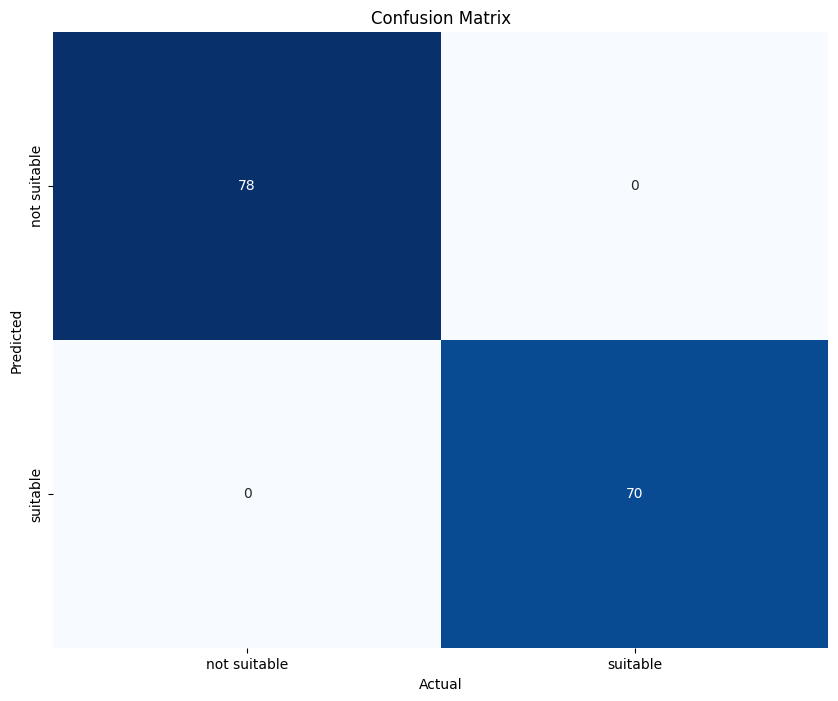

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


model_ft.eval()  # Set the model to evaluation mode

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

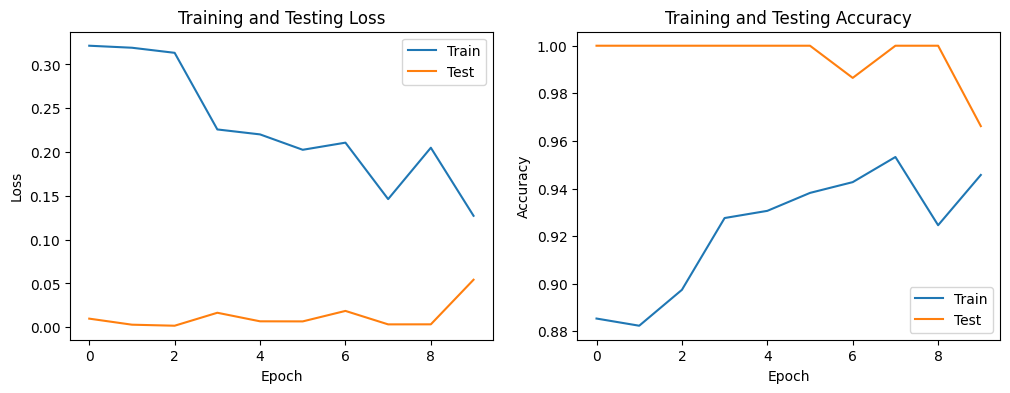

In [15]:
plt.figure(figsize=(12, 4))

# Plotting training and testing loss curves
plt.subplot(1, 2, 1)
plt.plot(training_history['Train_loss'], label='Train')
plt.plot(training_history['Test_loss'], label='Test')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and testing accuracy curves
plt.subplot(1, 2, 2)
plt.plot(training_history['Train_acc'], label='Train')
plt.plot(training_history['Test_acc'], label='Test')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
# Specify a directory where you have write permissions
from torch.utils.tensorboard import SummaryWriter

log_dir = "/tmp/tensorboard_logs"

# Create the TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)


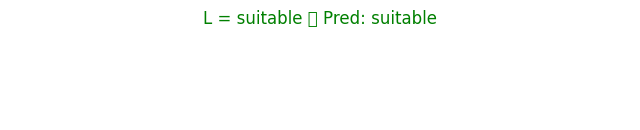

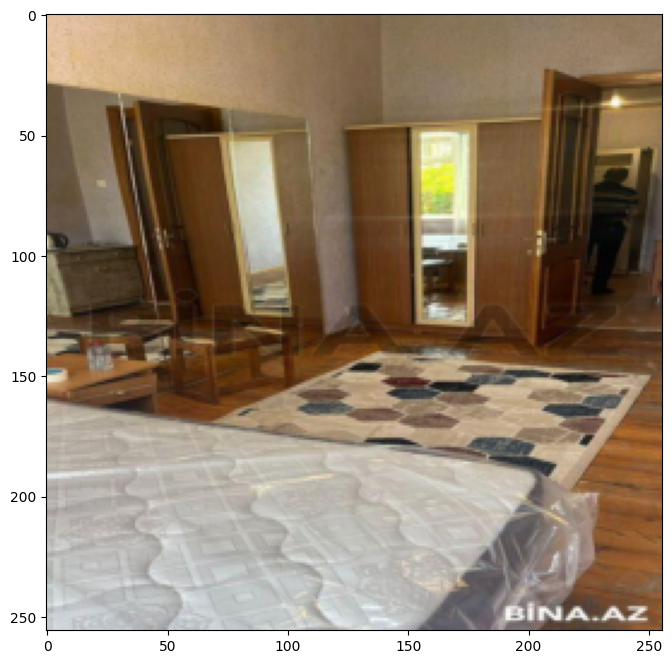

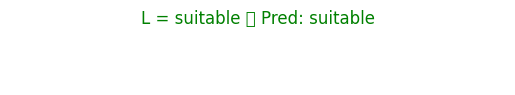

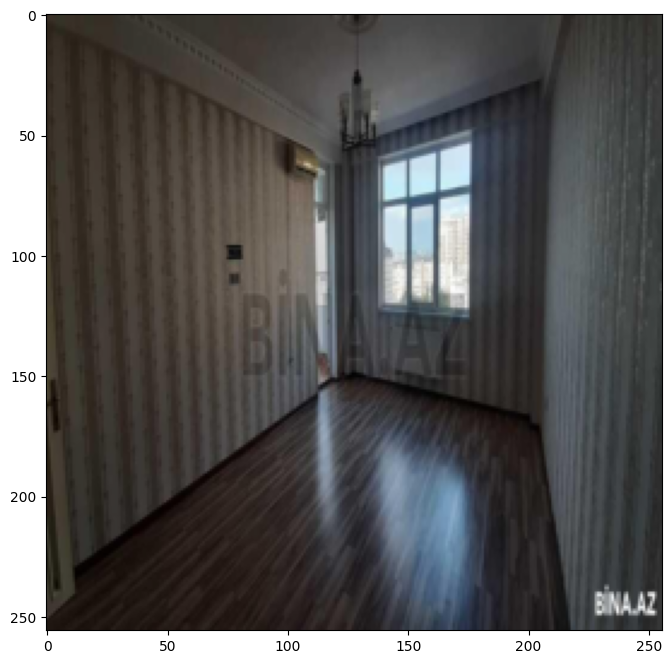

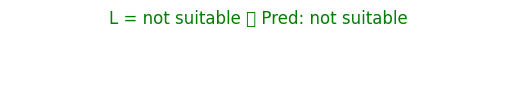

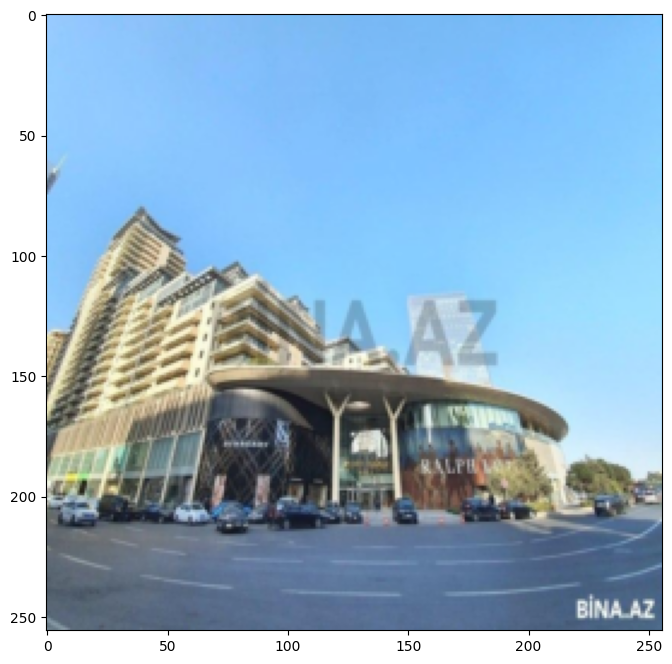

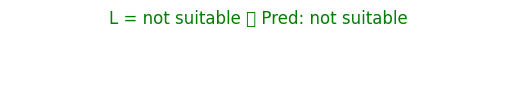

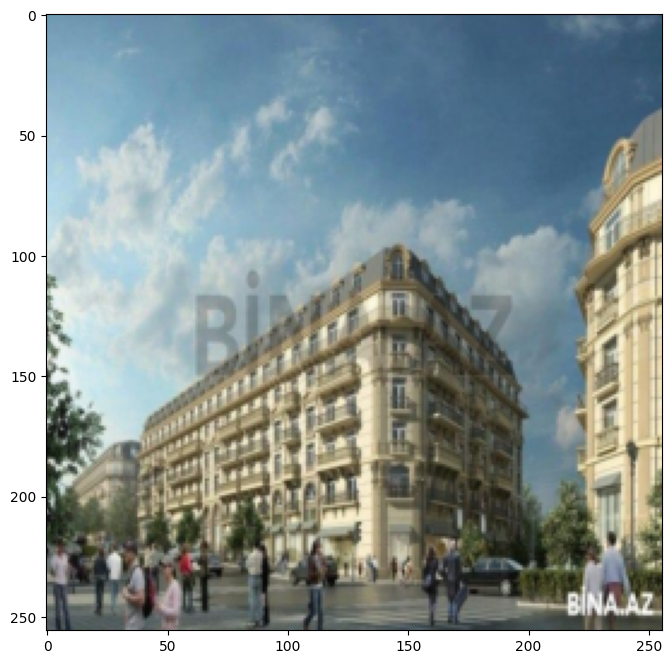

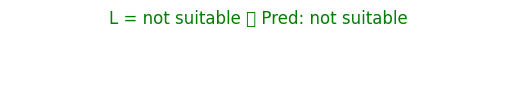

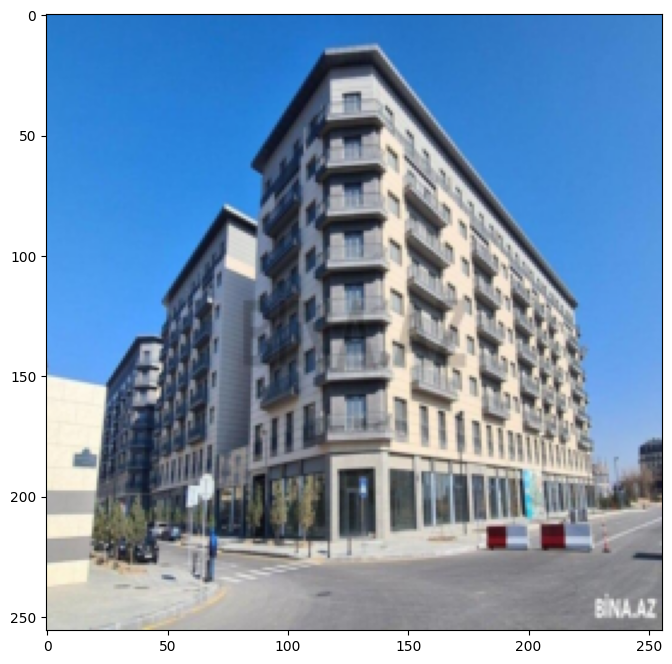

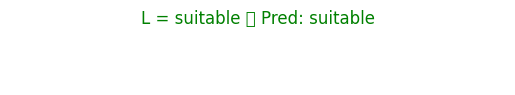

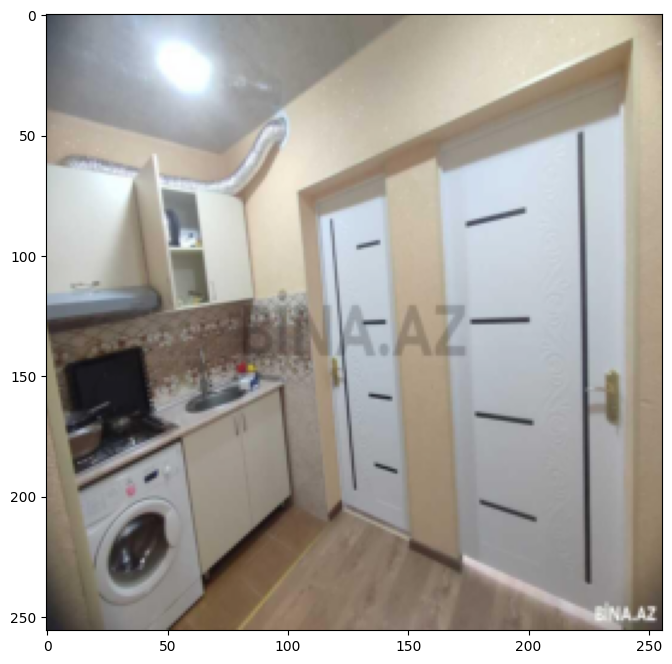

In [17]:
visualize_model(model_ft, dataloaders, writer, num_images=6)

In [18]:
# Save the model's state dictionary to a file
torch.save(model_ft.state_dict(), '/data/dss-data/managed_folders/MORTGAGEPRICECALCULATOR/Y2CfEnR1/model_unsampled.pt')
#print(model_ft.state_dict())

___

____

In [19]:
import os
import pickle
with open(os.path.join(dataiku.Folder('W0Wka5HT').get_path(), 'collected_arrays.pkl'), 'rb') as file:
    collected_images = pickle.load(file)

In [20]:
df=pd.DataFrame.from_dict(collected_images)

In [21]:
from PIL import Image

def pixels_to_image(pixel_array):
    # Create a PIL image from the pixel values
    img = Image.fromarray(pixel_array)
    return img

# Apply the pixels_to_image function to a range of rows in the DataFrame
image_subset = df['Pixels'][100:130].apply(pixels_to_image)


In [22]:
from torchvision import transforms

# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
from torchvision import models
import torch.nn as nn


# Define the model architecture (replace TheModelClass with your actual model class)
class_names = ['not suitable', 'suitable']

model_binary = models.resnet18(pretrained=True)
num_ftrs = model_binary.fc.in_features
model_binary.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the device
model_binary = model_binary.to(device)

# Load the trained weights
model_binary.load_state_dict(torch.load('/data/dss-data/managed_folders/MORTGAGEPRICECALCULATOR/Y2CfEnR1/model_unsampled.pt'))

# Set the model to evaluation mode
model_binary.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

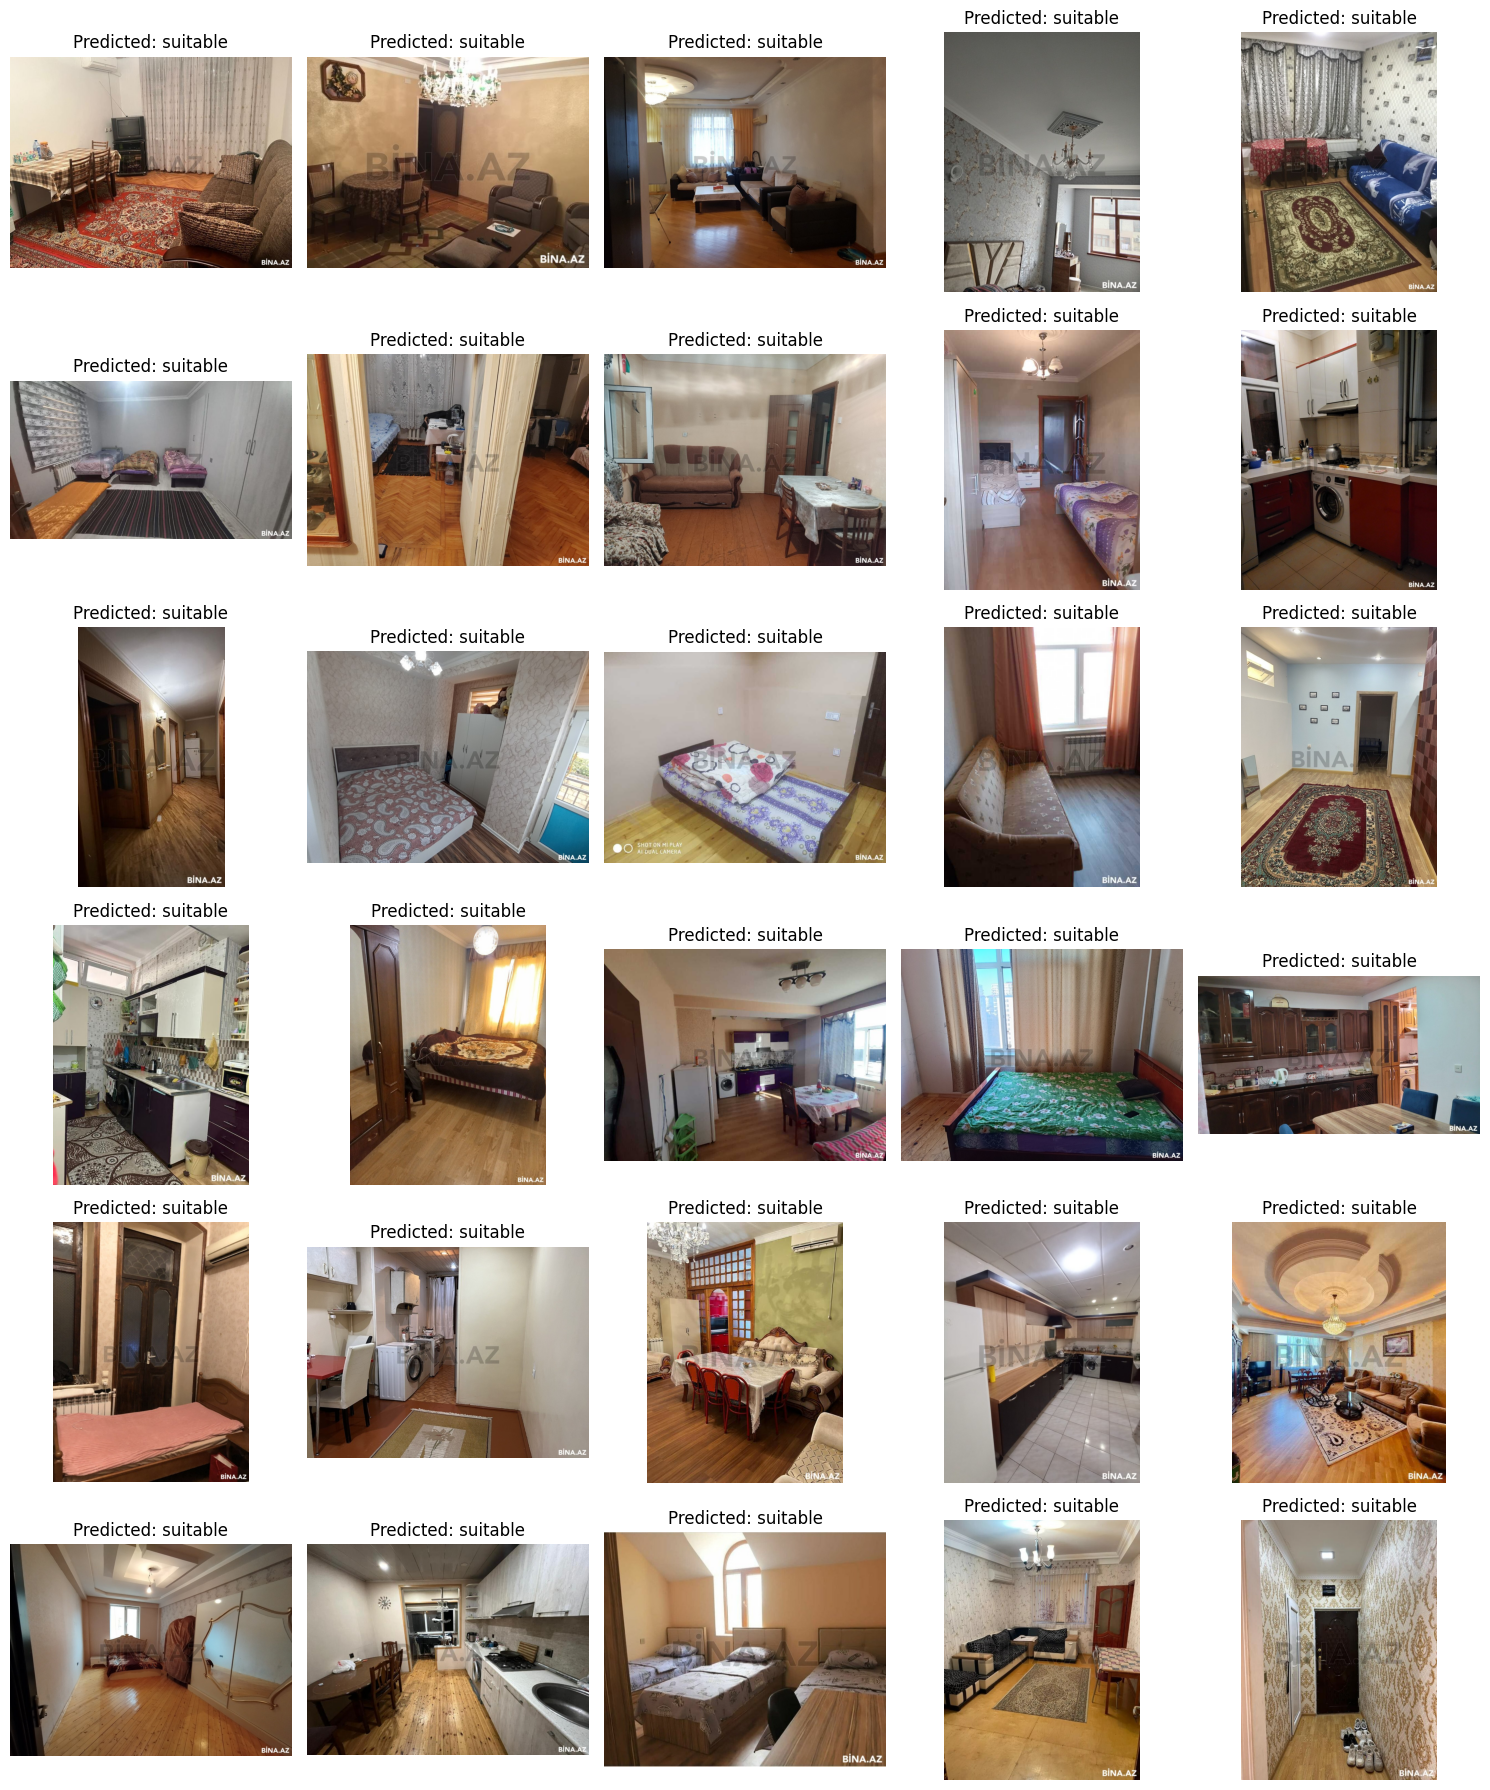

In [24]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# Assuming you have defined preprocess, image_subset, model_binary, and class_names

# Apply transformations to the image subset
input_tensors = [preprocess(image) for image in image_subset]

# Convert the list of input tensors to a batch tensor
input_batch = torch.stack(input_tensors)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Move the input tensor to the device
input_batch = input_batch.to(device)

# Perform inference
with torch.no_grad():
    output = model_binary(input_batch)

# Get the predicted class indices for each image in the batch
_, predicted_indices = torch.max(output, 1)

# Map the indices to the class names
predicted_classes = [class_names[idx.item()] for idx in predicted_indices]

# Calculate the grid size based on the number of images
num_images = len(image_subset)
rows = math.ceil(num_images / 5)  # 5 columns per row

# Display images along with predicted classes
fig, axs = plt.subplots(rows, 5, figsize=(15, 3 * rows))

for i, (image, predicted_class) in enumerate(zip(image_subset, predicted_classes)):
    row = i // 5
    col = i % 5

    # Display the image
    axs[row, col].imshow(image)
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Predicted: {predicted_class}')

# Adjust layout
plt.tight_layout()
plt.show()
